In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import time

import models
import flows

In [2]:
mhnn = models.MHNN(num_tasks=1000, dim=50, name="mhnn")
mhnn.restore()

permutation = list(np.arange(26, 51, 1)) + list(np.arange(0, 26, 1))
nf = flows.MAF(
    dim=51,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf",
)
nf.restore()

#### Figure 1

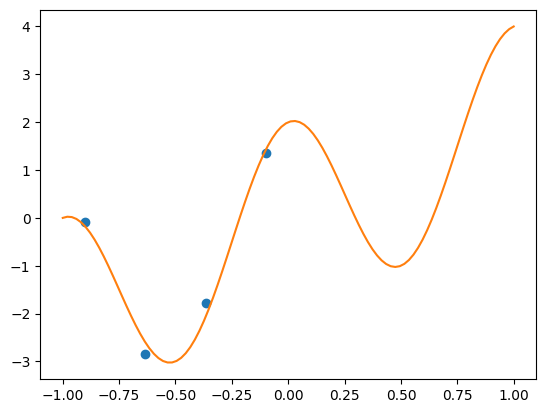

In [3]:
np.random.seed(1234) # for case 1
# np.random.seed(6666) # for case 2
x_test = np.linspace(-1, 1, 100).reshape([-1, 1])

# case 1
x_train = np.linspace(-0.9, -0.1, 4).reshape([-1, 1])
A = 2
w = 2 * np.pi
k = +1

noise = 0.2

y_train = A * np.cos(w * x_train) + 2 * k * x_train
y_train = y_train + noise * np.random.normal(size=y_train.shape)
y_test = A * np.cos(w * x_test) + 2 * k * x_test


plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test)

In [4]:
LA = models.LA(mhnn=mhnn, flow=nf, dim=50, noise=noise)

In [5]:
loss = LA.train(x_train, y_train, niter=20000)

0 172.5185
1000 -22.655365
2000 -80.30672
3000 -124.75023
4000 -169.02208
5000 -180.5232
6000 -185.1132
7000 -189.62852
8000 -195.4201
9000 -201.07002
10000 -209.8212
11000 -213.36412
12000 -213.45668
13000 -213.45844
14000 -213.44643
15000 -213.45566
16000 -213.43451
17000 -213.44733
18000 -213.45285
19000 -213.38675


In [6]:
LA.restore()
x_train_tf = tf.constant(x_train, tf.float32)
y_train_tf = tf.constant(y_train, tf.float32)

@tf.function
def Hessian():
    with tf.GradientTape() as tape_xx:
        with tf.GradientTape() as tape_x:
            neg_MAP = LA.neg_log_posterior(x_train_tf, y_train_tf)
        neg_MAP_x = tape_x.gradient(neg_MAP, LA.head)# [..., 0]
    neg_MAP_xx = tape_xx.jacobian(neg_MAP_x, LA.head)# [..., 0]
    return neg_MAP_xx

In [7]:
H = Hessian()
cov = tf.linalg.inv(H[:, 0, :, 0]).numpy()
cov = (cov + cov.T) / 2 # + 1e-8 * np.eye(51)
mean = LA.head.numpy().flatten()

In [8]:
samples = np.random.multivariate_normal(mean, cov, size=1000)
samples = tf.constant(samples, tf.float32)

In [9]:
heads = tf.transpose(samples)
y_pred = mhnn.call(
    tf.constant(x_test, tf.float32), heads
)
y_pred = y_pred.numpy()

mu = np.mean(y_pred, axis=1)
std = np.std(y_pred, axis=1)

Text(0.5, 1.0, 'LA')

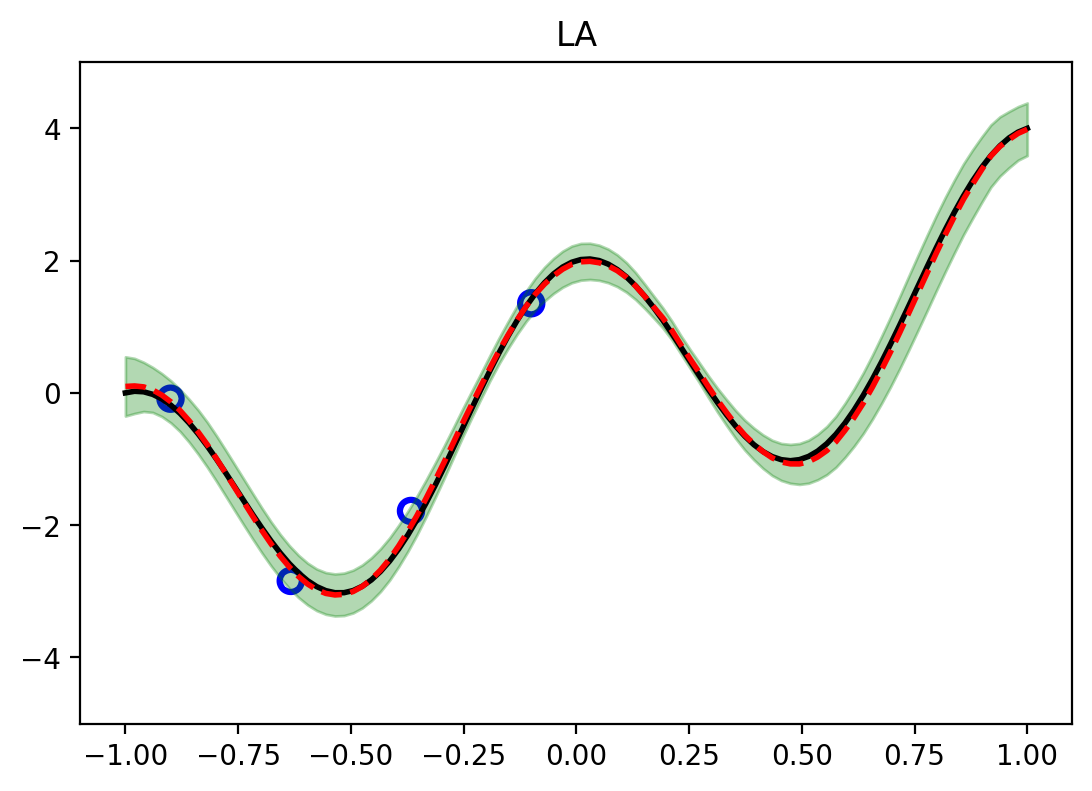

In [10]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.scatter(x_train, y_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test, y_test, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test, mu, color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x_test.flatten(), (mu+2*std), (mu-2*std), alpha=0.3, color="green", label="2 std")
# ax.legend(loc=0)
ax.set_ylim([-5, 5])
ax.set_box_aspect(2/3)
ax.set_title("LA")
# fig.savefig("case_2_2_la.png")
# fig.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_regularized.png")

Text(0.5, 1.0, 'LA')

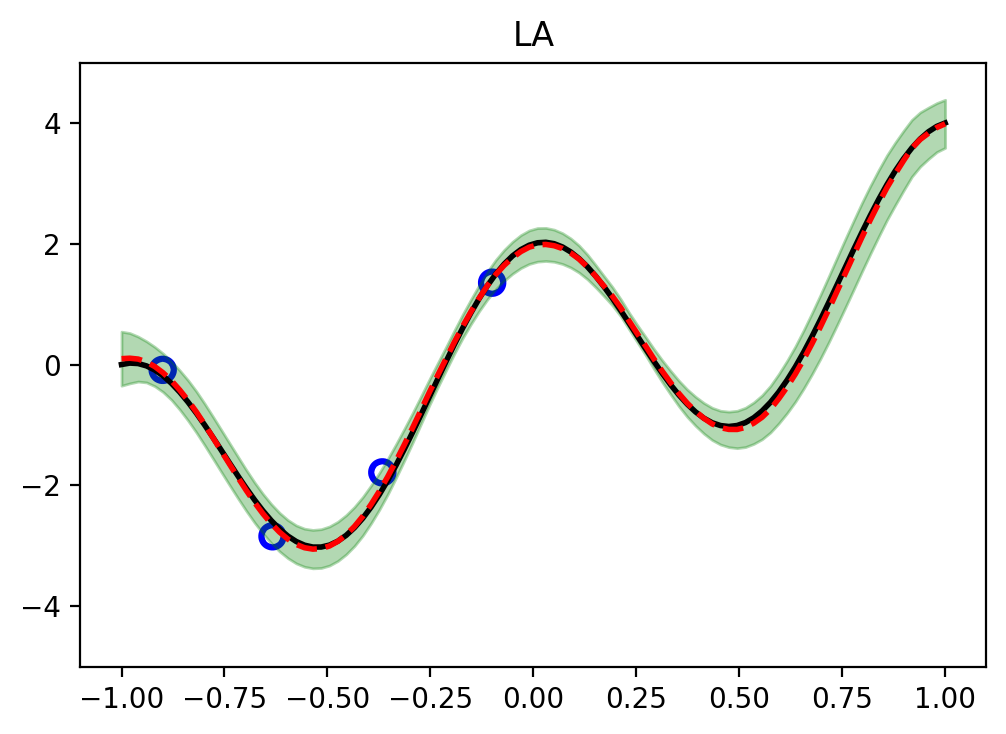

In [10]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.scatter(x_train, y_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test, y_test, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test, mu, color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x_test.flatten(), (mu+2*std), (mu-2*std), alpha=0.3, color="green", label="2 std")
# ax.legend(loc=0)
ax.set_ylim([-5, 5])
ax.set_box_aspect(2/3)
ax.set_title("LA")
# fig.savefig("case_2_2_la.png")
# fig.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_regularized.png")

In [11]:
sio.savemat(
    "./plot/case_1_la.mat",
    {
        "x_train": x_train,
        "u_train": y_train,
        "x_test": x_test,
        "y_test": y_test,
        "mu": mu, "std": std,
    }
)

#### Figure 2

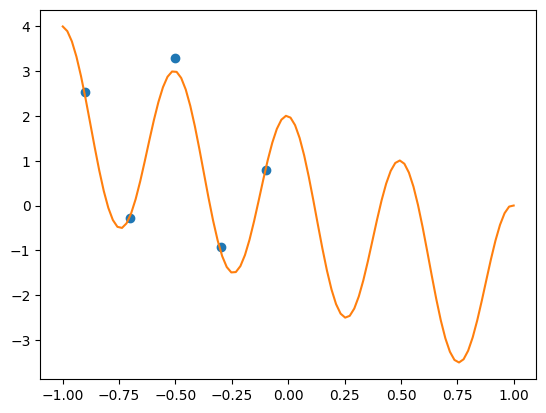

In [11]:
np.random.seed(6666) # for case 2
x_test = np.linspace(-1, 1, 100).reshape([-1, 1])

# case 2
x_train = np.linspace(-0.9, -0.1, 5).reshape([-1, 1])
A = 2
w = 4 * np.pi
k = -1

noise = 0.2

y_train = A * np.cos(w * x_train) + 2 * k * x_train
y_train = y_train + noise * np.random.normal(size=y_train.shape)
y_test = A * np.cos(w * x_test) + 2 * k * x_test

plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test)

In [12]:
LA = models.LA(mhnn=mhnn, flow=nf, dim=50, noise=noise)

In [13]:
loss = LA.train(x_train, y_train, niter=20000)

0 -144.3056
1000 -198.75487
2000 -204.90633
3000 -205.18472
4000 -205.18748
5000 -205.1646
6000 -205.17564
7000 -205.18773
8000 -205.1879
9000 -205.18596
10000 -205.18596
11000 -205.18192
12000 -205.1878
13000 -205.18768
14000 -205.16774
15000 -205.17995
16000 -205.1879
17000 -205.18216
18000 -205.18779
19000 -205.18745


In [14]:
LA.restore()
x_train_tf = tf.constant(x_train, tf.float32)
y_train_tf = tf.constant(y_train, tf.float32)

@tf.function
def Hessian():
    with tf.GradientTape() as tape_xx:
        with tf.GradientTape() as tape_x:
            neg_MAP = LA.neg_log_posterior(x_train_tf, y_train_tf)
        neg_MAP_x = tape_x.gradient(neg_MAP, LA.head)# [..., 0]
    neg_MAP_xx = tape_xx.jacobian(neg_MAP_x, LA.head)# [..., 0]
    return neg_MAP_xx

In [15]:
H = Hessian()
cov = tf.linalg.inv(H[:, 0, :, 0]).numpy()
cov = (cov + cov.T) / 2 # + 1e-8 * np.eye(51)
mean = LA.head.numpy().flatten()

In [16]:
samples = np.random.multivariate_normal(mean, cov, size=1000)
samples = tf.constant(samples, tf.float32)

In [17]:
heads = tf.transpose(samples)
y_pred = mhnn.call(
    tf.constant(x_test, tf.float32), heads
)
y_pred = y_pred.numpy()

mu = np.mean(y_pred, axis=1)
std = np.std(y_pred, axis=1)

Text(0.5, 1.0, 'LA')

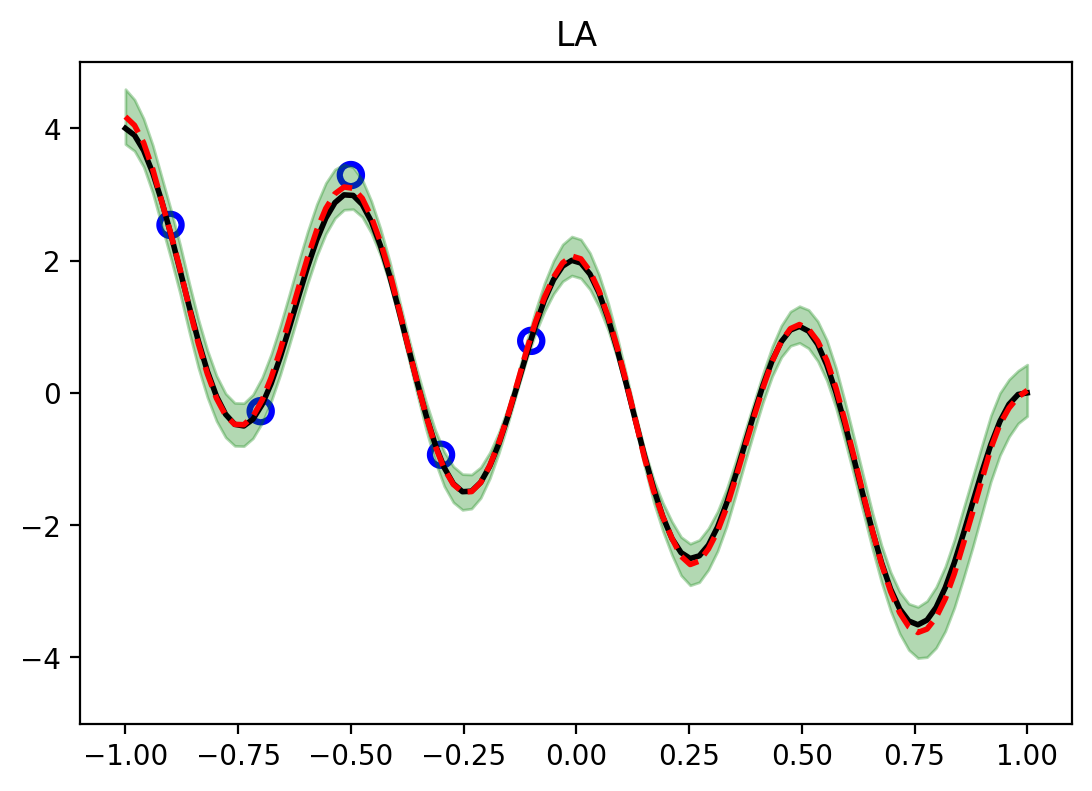

In [18]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.scatter(x_train, y_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test, y_test, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test, mu, color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x_test.flatten(), (mu+2*std), (mu-2*std), alpha=0.3, color="green", label="2 std")
# ax.legend(loc=0)
ax.set_ylim([-5, 5])
ax.set_box_aspect(2/3)
ax.set_title("LA")
# fig.savefig("case_2_2_la.png")
# fig.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_regularized.png")

Text(0.5, 1.0, 'LA')

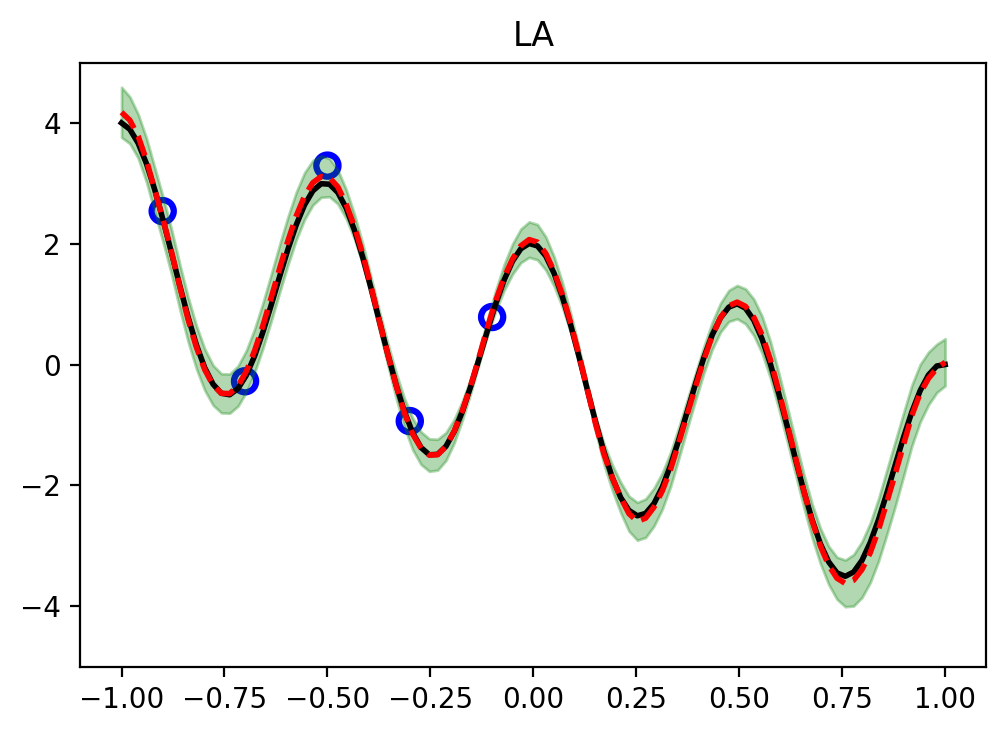

In [19]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.scatter(x_train, y_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test, y_test, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test, mu, color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x_test.flatten(), (mu+2*std), (mu-2*std), alpha=0.3, color="green", label="2 std")
# ax.legend(loc=0)
ax.set_ylim([-5, 5])
ax.set_box_aspect(2/3)
ax.set_title("LA")
# fig.savefig("case_2_2_la.png")
# fig.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_no_regularized.png")
# plt.savefig("case_1_3_regularized.png")

In [20]:
sio.savemat(
    "./plot/case_2_la.mat",
    {
        "x_train": x_train,
        "u_train": y_train,
        "x_test": x_test,
        "y_test": y_test,
        "mu": mu, "std": std,
    }
)